In [5]:
import typing
from automaticTB.examples.structures import get_perovskite_structure
from automaticTB.SALCs import VectorSpace, decompose_vectorspace_to_namedLC
from automaticTB.interaction import get_free_interaction_AO, InteractionEquation
from automaticTB.atomic_orbitals import AO
from automaticTB.printing import print_ao_pairs, print_matrix, print_InteractionPairs
from automaticTB.examples.Perovskite.ao_interaction import (
    get_interaction_values_from_list_AOpairs, get_overlap_values_from_list_AOpairs
)

structure = get_perovskite_structure()
print("Solving for the free nearest neighbor interaction in Perovskite")
print("Starting ...")

equation_systems: typing.List[InteractionEquation] = []

for i, nncluster in enumerate(structure.nnclusters):
    print("Cluster centered on " + str(nncluster.crystalsites[nncluster.origin_index]))
    print(nncluster.sitesymmetrygroup.groupname)
    vectorspace = VectorSpace.from_NNCluster(nncluster)
    named_lcs = decompose_vectorspace_to_namedLC(vectorspace, nncluster.sitesymmetrygroup)
    #for nlc in named_lcs:
    #    print(nlc.name)
    #    print(nlc.lc)
    print("Solve Interaction ...")
    equation = InteractionEquation.from_nncluster_namedLC(nncluster, named_lcs)

    print_ao_pairs(nncluster, equation.free_AOpairs)
    equation_systems.append(equation)


Solving for the free nearest neighbor interaction in Perovskite
Starting ...
Cluster centered on Pb @ (  0.00,  0.00,  0.00)  0 t = +0.0+0.0+0.0
m-3m
Solve Interaction ...
Free interaction parameters: 
  1 > Free AO interaction: Pb 1px -> Cl 1px @ (  0.00,  2.84,  0.00)
  2 > Free AO interaction: Pb 1px -> Cl 1s @ (  2.84,  0.00,  0.00)
  3 > Free AO interaction: Pb 1px -> Cl 1px @ (  2.84,  0.00,  0.00)
  4 > Free AO interaction: Pb 1px -> Pb 1px @ (  0.00,  0.00,  0.00)
  5 > Free AO interaction: Pb 1s -> Cl 1s @ (  2.84,  0.00,  0.00)
  6 > Free AO interaction: Pb 1s -> Cl 1px @ (  2.84,  0.00,  0.00)
  7 > Free AO interaction: Pb 1s -> Pb 1s @ (  0.00,  0.00,  0.00)
Cluster centered on Cl @ (  0.00,  0.00,  0.00)  1 t = +0.0+0.0+0.0
4/mmm
Solve Interaction ...
Free interaction parameters: 
  1 > Free AO interaction: Cl 1pz -> Cl 1pz @ (  0.00,  0.00,  0.00)
  2 > Free AO interaction: Cl 1s -> Pb 1s @ (  2.84,  0.00,  0.00)
  3 > Free AO interaction: Cl 1s -> Pb 1px @ (  2.84,  0.00

In [6]:
from automaticTB.interaction import InteractionPairs
from automaticTB.tightbinding import TightBindingModel, gather_InteractionPairs_into_HijRs, gather_InteractionPairs_into_SijRs

all_interaction_pairs: typing.List[InteractionPairs] = []
all_overlaps_pairs: typing.List[InteractionPairs] = []

# we build the Hamiltonian and Overlap matrix
for equation in equation_systems:
    free_pairs = equation.free_AOpairs
        
    hamiltonian_values = get_interaction_values_from_list_AOpairs(structure.cell, structure.positions, free_pairs)
    overlap_values = get_overlap_values_from_list_AOpairs(free_pairs)

    cluster_interactions = equation.solve_interactions_to_InteractionPairs(hamiltonian_values)
    cluster_overlap = equation.solve_interactions_to_InteractionPairs(overlap_values)

    all_interaction_pairs.append(cluster_interactions)
    all_overlaps_pairs.append(cluster_overlap)

hijRs = gather_InteractionPairs_into_HijRs(all_interaction_pairs)
SijRs = gather_InteractionPairs_into_SijRs(all_overlaps_pairs)

perovskiet_TBmodel = TightBindingModel(structure.cell, structure.positions, structure.types, hijRs, SijRs)

Plot the bandstructure


0

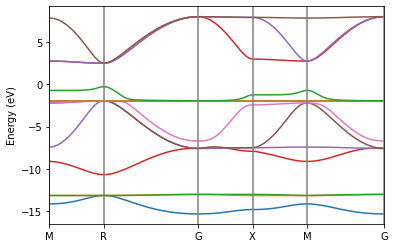

In [8]:
from automaticTB.examples.kpaths import cubic_kpath
from automaticTB.properties.bandstructure import BandStructureResult
import os

filename = "HalidePerovskite.pdf"

print("Plot the bandstructure")
band_result = BandStructureResult.from_tightbinding_and_kpath(perovskiet_TBmodel, cubic_kpath)
band_result.plot_data(filename)

os.system(f"rm {filename}") # delete the temporary file

0

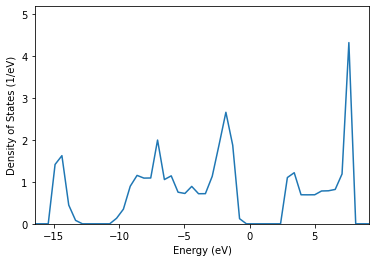

In [9]:
from automaticTB.properties.dos import get_tetrados_result
import numpy as np

tetrados = get_tetrados_result(perovskiet_TBmodel, ngrid=np.array([10,10,10]))
tetrados.plot_data(filename)
os.system(f"rm {filename}")